<a href="https://colab.research.google.com/github/eseguraca6/Quantum-Computing-Playground/blob/master/QAOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import numpy as np
!pip install git+https://github.com/quantumlib/Cirq
  
import matplotlib.pyplot as plt
from pandas import DataFrame
import cirq
from cirq.ops import CNOT, TOFFOLI
from cirq import Simulator
import random
import sympy
from cirq.circuits import InsertStrategy

from google.colab import auth
from oauth2client.client import GoogleCredentials

  Cloning https://github.com/quantumlib/Cirq to /tmp/pip-req-build-oz2v0sze
  Running command git clone -q https://github.com/quantumlib/Cirq /tmp/pip-req-build-oz2v0sze
  Stored in directory: /tmp/pip-ephem-wheel-cache-v1g8_cjn/wheels/c9/f4/ee/029123a49c5e2d75d08c2a9f937e207b88f045901db04632a7
Successfully built cirq


In [0]:
# This is the ADAM implementation of SGD. 
# I found through developing this simulation that it reduces running 
# time significantly. 
# For specific information regarding the algorithm, please see OpenAI's paper
# mentioned in this notebook. 

def QAOA_Model_Params_Optimizier_Adam(length, param1, param2,rep_num):
  
  param1_arr =[]
  param2_arr =[]
  
  gradient_arr = []
  loss_arr =[]
  label_arr =[]

  zero_state_arr =[]
  one_state_arr =[]
  
  delta_param1= []
  delta_param2= []
  
  delta_loss = []
  
  status = 'not done'
  count = 1
  
  #code to implement Learning Rate Optimization
  
  gradient_moment = 0 
  momentum_moment =0
  beta_1 = 0.9
  beta_2 = 0.999
  smoothing_epsilon = 1e-8
  learning_rate = 0.001
  
  count = 1
  
  while status == 'not done':
    #print("Working on Optimization...      ", end="")
    #get results
    #print('current count: ', count)
    #print('current weight:', random_t_parameter)
    
    param1_arr.append(param1)
    param2_arr.append(param2)
    
    #print(xlayer_arr)
    
    circuit = cirq.Circuit()
    
    test_circuit_label = QAOA_circuit(length, param1, param2)
    circuit.append(test_circuit_label,strategy=InsertStrategy.INLINE)
    
    #print(circuit)
    simulator = cirq.Simulator()
    
    results = simulator.run(circuit, repetitions=rep_num)
    
    #check the state population
    
    count_results = results.histogram(key='x')
  
    zero_state_arr.append(count_results[0]/rep_num)
    one_state_arr.append(count_results[1]/rep_num)
    
    s_k, s_v= zip(*results.measurements.items())
    
    #check for the loss function at this point
    #convert from 0,1 state count to -1,1
    
    current_state_values = 1 - 2*np.array(s_v).astype(np.int32)
    
    current_predicted_label_value = np.mean(current_state_values)
    
    label_arr.append(current_predicted_label_value)
  
    current_loss_value = 1 - np.square(current_predicted_label_value)
    
    loss_arr.append(current_loss_value)
    
    #print('current count: ', count, 'current loss: ', current_loss_value)
    
    current_gradient_value = 2*current_predicted_label_value
    gradient_arr.append(current_gradient_value)
    
    current_grad_square = np.square(current_gradient_value)
    
    if count > 1000:
      print('count is way too much!')
      status = 'done'
      return(param1_arr, param2_arr, loss_arr, gradient_arr, label_arr, zero_state_arr, one_state_arr)
    
    elif np.abs(current_loss_value) < 1e-6:
      status = 'done'
      
      optimal_values = [param1_arr[-1],param2_arr[-1]]
      print('Optimal values:', optimal_values)
      
      print('Done with Optimization Algorithm!')
      print('Optimal values:', optimal_values)
      cirq.plot_state_histogram(results)


    else:
      
      next_gradient_moment = beta_1*gradient_moment +(1-beta_1)*current_gradient_value
      #biased corrected first estimate 
      
      biased_gradient_moment = next_gradient_moment / (1- beta_1**count)
      
      #swap the value for the next iteration
      gradient_moment = next_gradient_moment 
      
      next_momentum_moment = beta_2*momentum_moment + (1-beta_2)*np.square(current_gradient_value)
      
      #biased corrected first estimate for momentum 
      biased_momentum_moment = next_momentum_moment / (1 - beta_2**count)
      
      #another swap
      momentum_moment = next_momentum_moment
      
      #adjust the weights to find optimal parameters 
      param1 = param1 -  learning_rate * biased_gradient_moment / (np.sqrt(biased_momentum_moment) + smoothing_epsilon)
      param2 = param2 - learning_rate * biased_gradient_moment / (np.sqrt(biased_momentum_moment) + smoothing_epsilon)
      #print('next parameters: ' ,param1, param2)     
      count = count +1
      
  return(param1_arr, param2_arr, loss_arr, gradient_arr, label_arr, zero_state_arr, one_state_arr, optimal_values,circuit)

def layer_h(length):
  
  h_gate = cirq.H
  
  for i in range(length-1):
      yield h_gate(cirq.LineQubit(i))
      
def layer_control_gate_rotation_z(length, parameter):
  
  control_gate = cirq.CNOT
  rotation_on_Z = cirq.ZPowGate(exponent=parameter)
  
  for i in range(length-2):
    yield control_gate(cirq.LineQubit(i), cirq.LineQubit(i+1)) 
    yield rotation_on_Z(cirq.LineQubit(i+1))
    yield control_gate(cirq.LineQubit(i), cirq.LineQubit(i+1))
    
def flipped_control_gate_system(length, parameter):
  
  control_gate = cirq.CNOT
  rotation_on_Z = cirq.ZPowGate(exponent=parameter)
  
  yield control_gate(cirq.LineQubit(length-2), cirq.LineQubit(0))
  yield rotation_on_Z(cirq.LineQubit(0))
  yield control_gate(cirq.LineQubit(length-2), cirq.LineQubit(0))
  
def layer_rotations_x(length, parameter):
  
  rot = cirq.XPowGate(exponent=parameter)
  
  for i in range(length-1):
      yield rot(cirq.LineQubit(i))  


def QAOA_circuit(length, param1, param2):
  #create the qubits for the circuit 
  qubits = [cirq.LineQubit(i) for i in range(length)]
  
  yield cirq.X(cirq.LineQubit(length-1))
  yield layer_h(length)
  yield layer_control_gate_rotation_z(length, 2*param1) 
  yield flipped_control_gate_system(length, 2*param1)
  yield layer_rotations_x(length, 2*param2)
  yield layer_h(length)
  
  #add the n-toffoli gate
  cnX = cirq.X.controlled_by(*qubits[:-1])
  #cnX = cirq.X.controlled_by(cirq.LineQubit(0), cirq.LineQubit(1),  cirq.LineQubit(2),cirq.LineQubit(3))
  
  yield cnX(cirq.LineQubit(length-1))
  #yield cirq.Y(cirq.LineQubit(4))
  #yield cirq.Z(cirq.LineQubit(4))
  yield cirq.measure(cirq.LineQubit(length-1), key='x')

In [147]:
length=5

circuit = cirq.Circuit()

beta = sympy.Symbol('beta')
gamma = sympy.Symbol('gamma')

circuit.append(QAOA_circuit(length, gamma, beta),strategy=InsertStrategy.INLINE)
#circuit.append(cirq.measure(*qubits[:length-1]),strategy=InsertStrategy.INLINE)
print(circuit)


0: ───H───@─────────────────@───────────────────────────────────────────────X───Z^(2*gamma)───X───X^(2*beta)───H───@────────────
          │                 │                                               │                 │                    │
1: ───H───X───Z^(2*gamma)───X───@─────────────────@─────────────────────────┼─────────────────┼───X^(2*beta)───H───@────────────
                                │                 │                         │                 │                    │
2: ───H─────────────────────────X───Z^(2*gamma)───X───@─────────────────@───┼─────────────────┼───X^(2*beta)───H───@────────────
                                                      │                 │   │                 │                    │
3: ───H───────────────────────────────────────────────X───Z^(2*gamma)───X───@─────────────────@───X^(2*beta)───H───@────────────
                                                                                                                   │
4: ───X─────────

Initial Phase Parameters:  1.231432731349687 1.1769433685253632
0: ───H───@─────────────@───────────────────────────────────────X───Z^0.463───X───X^0.354───H───@────────────
          │             │                                       │             │                 │
1: ───H───X───Z^0.463───X───@─────────────@─────────────────────┼─────────────┼───X^0.354───H───@────────────
                            │             │                     │             │                 │
2: ───H─────────────────────X───Z^0.463───X───@─────────────@───┼─────────────┼───X^0.354───H───@────────────
                                              │             │   │             │                 │
3: ───H───────────────────────────────────────X───Z^0.463───X───@─────────────@───X^0.354───H───@────────────
                                                                                                │
4: ───X─────────────────────────────────────────────────────────────────────────────────────────X───M('x

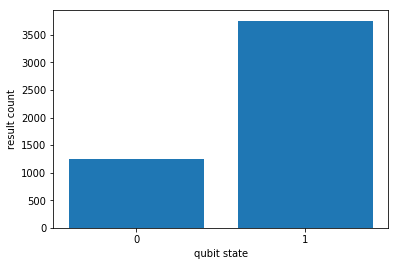

array([1245., 3755.])

In [155]:
circuit = cirq.Circuit()

param1, param2= np.random.uniform(0,2) ,np.random.uniform(0,2)
print('Initial Phase Parameters: ',param1, param2)

circuit.append(QAOA_circuit(length, param1, param2),strategy=InsertStrategy.INLINE)

print(circuit)

simulator = cirq.Simulator()

results = simulator.run(circuit, repetitions=5000)

cirq.plot_state_histogram(results)

Initial Phase Parameters:  1.231432731349687 1.1769433685253632
Optimal values: [1.474492853155287, 1.4200034903309633]
Done with Optimization Algorithm!
Optimal values: [1.474492853155287, 1.4200034903309633]


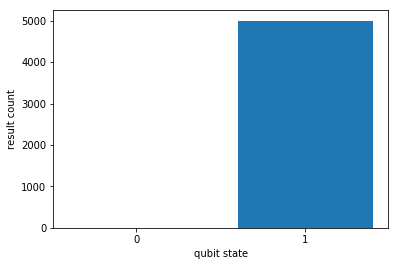

In [156]:
print('Initial Phase Parameters: ',param1, param2)
#param1,param2= 1.041,1.907
ml_qaoa = QAOA_Model_Params_Optimizier_Adam(length, param1,param2,5000)

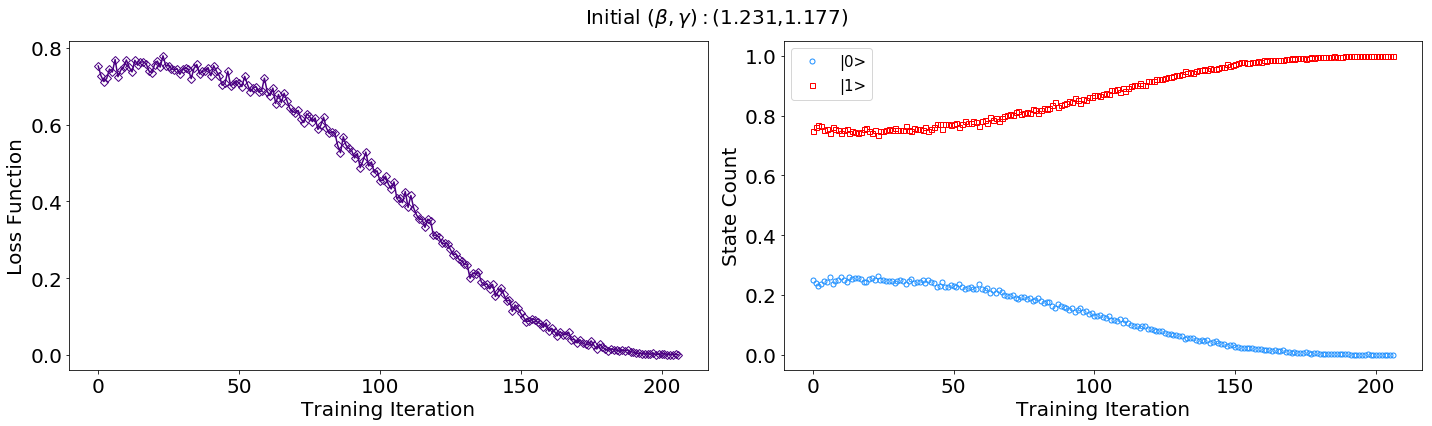

In [157]:
from google.colab import files

#return(param1_arr, param2_arr, loss_arr, gradient_arr, label_arr, zero_state_arr, one_state_arr, optimal_values)

plt.figure(figsize=(20,6))

plt.subplot(121)
plt.plot(ml_qaoa[2],marker='D',linestyle='-',color='indigo',markerfacecolor='none')
plt.tick_params(axis='both',labelsize=20)
plt.ylabel('Loss Function',fontsize=20)
plt.xlabel('Training Iteration',fontsize=20)

plt.subplot(122)
plt.plot(ml_qaoa[5],marker='o',markersize=5,label='|0>',color='dodgerblue',linestyle=' ',markerfacecolor='none')
plt.plot(ml_qaoa[6],marker='s',markersize=5, label='|1>',color='red',linestyle=' ',markerfacecolor='none')
plt.legend(loc='best', fontsize=15)
plt.ylabel('State Count',fontsize=20)
plt.xlabel('Training Iteration',fontsize=20)
plt.tick_params(axis='both',labelsize=20)

plt.suptitle(r'Initial $(\beta, \gamma):$'+ '('+str(np.round(param1,3))+','+str(np.round(param2,3))+')',fontsize=20 )
plt.tight_layout()
plt.subplots_adjust(top=.9)

plt.savefig('badoutput_small_qaoa.png')


#files.download('badoutput_small_qaoa.png')

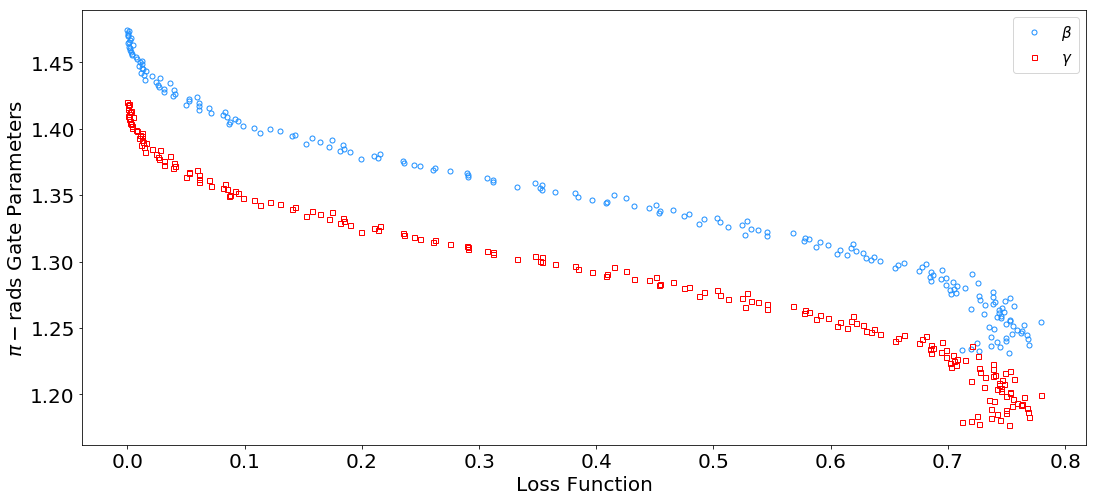

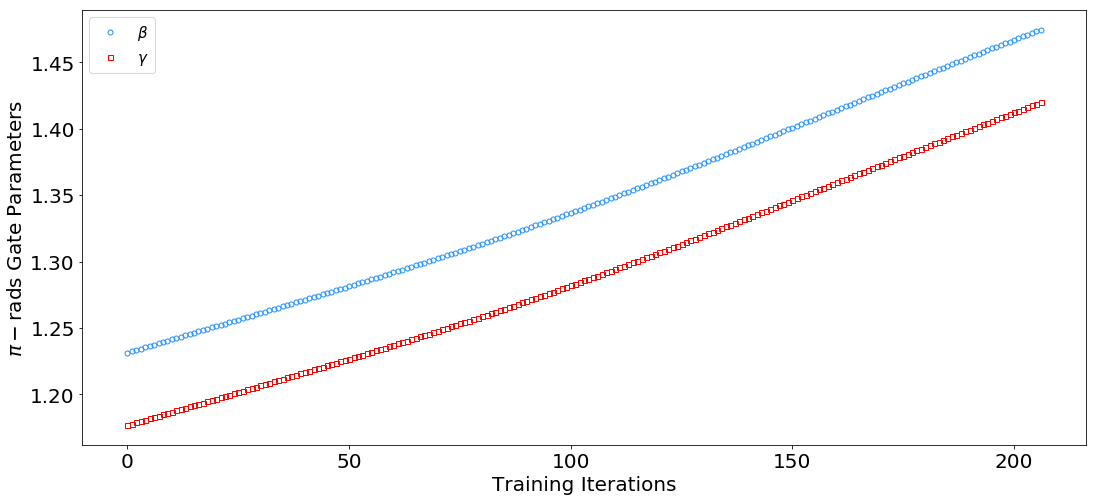

In [158]:
plt.figure(figsize=(18,8))

plt.plot(ml_qaoa[2],ml_qaoa[0],marker='o',markersize=5,label=r'$\beta$',color='dodgerblue',linestyle=' ',markerfacecolor='none')
plt.plot(ml_qaoa[2],ml_qaoa[1],marker='s',markersize=5, label=r'$\gamma$',color='red',linestyle=' ',markerfacecolor='none')
plt.legend(loc='best', fontsize=15)
plt.ylabel(r'$\pi-$rads Gate Parameters',fontsize=20)
plt.xlabel('Loss Function',fontsize=20)
plt.tick_params(axis='both',labelsize=20)

plt.figure(figsize=(18,8))
plt.plot(ml_qaoa[0],marker='o',markersize=5,label=r'$\beta$',color='dodgerblue',linestyle=' ',markerfacecolor='none')
plt.plot(ml_qaoa[1],marker='s',markersize=5, label=r'$\gamma$',color='red',linestyle=' ',markerfacecolor='none')
plt.legend(loc='best', fontsize=15)
plt.ylabel(r'$\pi-$rads Gate Parameters',fontsize=20)
plt.xlabel('Training Iterations',fontsize=20)
plt.tick_params(axis='both',labelsize=20)


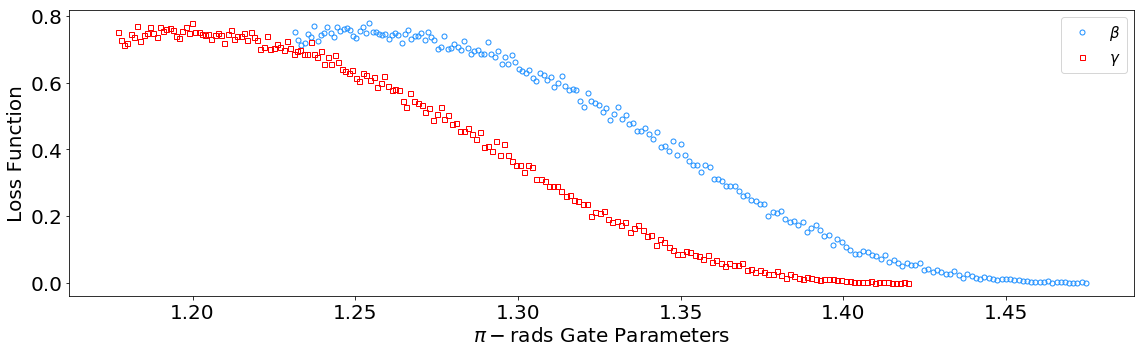

In [159]:
plt.figure(figsize=(16,5))
plt.plot(ml_qaoa[0],ml_qaoa[2],marker='o',markersize=5,label=r'$\beta$',color='dodgerblue',linestyle=' ',markerfacecolor='none')
plt.plot(ml_qaoa[1],ml_qaoa[2],marker='s',markersize=5, label=r'$\gamma$',color='red',linestyle=' ',markerfacecolor='none')
plt.legend(loc='best', fontsize=15)
plt.xlabel(r'$\pi-$rads Gate Parameters',fontsize=20)
plt.ylabel('Loss Function',fontsize=20)
plt.tick_params(axis='both',labelsize=20)

plt.tight_layout()

In [161]:
print('Optimized Parameters: ', ml_qaoa[-2])

circuit = cirq.Circuit()

circuit.append(QAOA_circuit(length, ml_qaoa[7][0], ml_qaoa[7][1]),strategy=InsertStrategy.INLINE)
#circuit.append(cirq.measure(*qubits[:length-1]),strategy=InsertStrategy.INLINE)

print(circuit)

Optimized Parameters:  [1.474492853155287, 1.4200034903309633]
0: ───H───@─────────────@───────────────────────────────────────X───Z^0.949───X───X^0.84───H───@────────────
          │             │                                       │             │                │
1: ───H───X───Z^0.949───X───@─────────────@─────────────────────┼─────────────┼───X^0.84───H───@────────────
                            │             │                     │             │                │
2: ───H─────────────────────X───Z^0.949───X───@─────────────@───┼─────────────┼───X^0.84───H───@────────────
                                              │             │   │             │                │
3: ───H───────────────────────────────────────X───Z^0.949───X───@─────────────@───X^0.84───H───@────────────
                                                                                               │
4: ───X────────────────────────────────────────────────────────────────────────────────────────X───M('x')───
